In [27]:
# cd /content/drive/My Drive/University/SEM7/CS4622_Machine_Learning/Project_1/Fair_Classification/

# Import Statements

In [28]:
# # pip install geopy
# !pip install folium

In [29]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
# import folium
# from folium import FeatureGroup, LayerControl, Map, Marker
# from folium.plugins import HeatMap
# from folium.plugins import TimestampedGeoJson
# from folium.plugins import MarkerCluster
from geopy.distance import great_circle
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
from geopy.distance import geodesic

# Load Data

In [30]:
train  = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

In [31]:
print (train[train.label == 'incorrect'].shape[0])

1681


In [32]:
test.info()
# train.isna().sum() 
# test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8576 entries, 0 to 8575
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     8576 non-null   int64  
 1   additional_fare            8576 non-null   float64
 2   duration                   8576 non-null   int64  
 3   meter_waiting              8576 non-null   int64  
 4   meter_waiting_fare         8576 non-null   float64
 5   meter_waiting_till_pickup  8576 non-null   int64  
 6   pickup_time                8576 non-null   object 
 7   drop_time                  8576 non-null   object 
 8   pick_lat                   8576 non-null   float64
 9   pick_lon                   8576 non-null   float64
 10  drop_lat                   8576 non-null   float64
 11  drop_lon                   8576 non-null   float64
 12  fare                       8576 non-null   float64
dtypes: float64(7), int64(4), object(2)
memory usage:

# Data Cleaning

## Flag Outliers

In [33]:
print('Old size: %d' % len(train))
mean, std  =train.additional_fare.mean() , train.additional_fare.std()
train['additional_fare_is_outlier'] = train['additional_fare'].apply(lambda x: 0 if (np.abs(x-mean) <= (3*std)) else 1)
test['additional_fare_is_outlier'] = test['additional_fare'].apply(lambda x: 0 if (np.abs(x-mean) <= (3*std)) else 1)
print('New size: %d' % len(train))
print (train[train.additional_fare_is_outlier == 1].shape[0])
print (train[train.label == 'incorrect'].shape[0])

Old size: 17176
New size: 17176
204
1681


In [34]:
print('Old size: %d' % len(train))
mean, std  =train.meter_waiting_fare.mean() , train.meter_waiting_fare.std()
train['meter_waiting_fare_is_outlier'] = train['meter_waiting_fare'].apply(lambda x: 0 if (np.abs(x-mean) <= (3*std)) else 1)
test['meter_waiting_fare_is_outlier'] = test['meter_waiting_fare'].apply(lambda x: 0 if (np.abs(x-mean) <= (3*std)) else 1)
print('New size: %d' % len(train))
print (test[test.meter_waiting_fare_is_outlier == 1].shape[0])
print (train[train.label == 'incorrect'].shape[0])

Old size: 17176
New size: 17176
22
1681


In [35]:
print('Old size: %d' % len(train))
mean, std  =train.fare.mean() , train.fare.std()
train['fare_is_outlier'] = train['fare'].apply(lambda x: 0 if ((np.abs(x-mean) <= (3*std)) or x<=0 ) else 1)
test['fare_is_outlier'] = test['fare'].apply(lambda x: 0 if ((np.abs(x-mean) <= (3*std)) or x<=0 ) else 1)
print('New size: %d' % len(train))
print (train[train.fare_is_outlier == 1].shape[0])
print (train[train.label == 'incorrect'].shape[0])

Old size: 17176
New size: 17176
225
1681


## Fill null values

In [36]:
# train = train.fillna(-1)
# test = test.fillna(-1)

## Drop outliers

In [37]:
# print('Old size: %d' % len(train))
# train = train[np.abs(train.duration-train.duration.mean()) <= (3*train.duration.std())]
# print('New size: %d' % len(train))
# print (train[train.label == 'incorrect'].shape[0])

In [38]:
# print('Old size: %d' % len(train))
# train = train[np.abs(train.meter_waiting_till_pickup-train.meter_waiting_till_pickup.mean()) <= (3*train.meter_waiting_till_pickup.std())]
# print('New size: %d' % len(train))
# print (train[train.label == 'incorrect'].shape[0])

In [39]:
# print('Old size: %d' % len(train))
# train = train[np.abs(train.meter_waiting-train.meter_waiting.mean()) <= (3*train.meter_waiting.std())]
# print('New size: %d' % len(train))
# print (train[train.label == 'incorrect'].shape[0])

## Format date and Lables

In [40]:
train['pickup_time']=pd.to_datetime(train['pickup_time'],infer_datetime_format=True)
train['drop_time']=pd.to_datetime(train['drop_time'],infer_datetime_format=True)

test['pickup_time']=pd.to_datetime(test['pickup_time'],infer_datetime_format=True)
test['drop_time']=pd.to_datetime(test['drop_time'],infer_datetime_format=True)

In [41]:
train['pickup_date']= train['pickup_time'].dt.date
train['pickup_day']=train['pickup_time'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_time'].apply(lambda x:x.hour)
train['pickup_day_of_week']=train['pickup_time'].apply(lambda x:calendar.day_name[x.weekday()])
train['pickup_month']=train['pickup_time'].apply(lambda x:x.month)
train['pickup_year']=train['pickup_time'].apply(lambda x:x.year)

test['pickup_date']= test['pickup_time'].dt.date
test['pickup_day']=test['pickup_time'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_time'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_time'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_month']=test['pickup_time'].apply(lambda x:x.month)
test['pickup_year']=test['pickup_time'].apply(lambda x:x.year)

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   tripid                         17176 non-null  int64         
 1   additional_fare                16974 non-null  float64       
 2   duration                       16974 non-null  float64       
 3   meter_waiting                  16974 non-null  float64       
 4   meter_waiting_fare             16974 non-null  float64       
 5   meter_waiting_till_pickup      16974 non-null  float64       
 6   pickup_time                    17176 non-null  datetime64[ns]
 7   drop_time                      17176 non-null  datetime64[ns]
 8   pick_lat                       17176 non-null  float64       
 9   pick_lon                       17176 non-null  float64       
 10  drop_lat                       17176 non-null  float64       
 11  drop_lon       

In [43]:
def encodeDays(day_of_week):
  day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
  return day_dict[day_of_week]
def encodeLabel(label):
  label_dict={'correct':1,'incorrect':0}
  return label_dict[label]
def clean_data(data,isTrain):
  data['pickup_day_of_week']=data['pickup_day_of_week'].apply(lambda x:encodeDays(x))
  if(isTrain):
    data['label']=data['label'].apply(lambda x:encodeLabel(x))
  return data

In [44]:
train=clean_data(train,True)
test=clean_data(test,False)
print("Shape of Training Data after cleaning ",train.shape)
print("Shape of Testing Data after cleaning", test.shape)


Shape of Training Data after cleaning  (17176, 23)
Shape of Testing Data after cleaning (8576, 22)


# EDA

In [45]:
train[pd.isnull(train)].sum()

tripid                           0.0
additional_fare                  0.0
duration                         0.0
meter_waiting                    0.0
meter_waiting_fare               0.0
meter_waiting_till_pickup        0.0
pickup_time                      0.0
drop_time                        0.0
pick_lat                         0.0
pick_lon                         0.0
drop_lat                         0.0
drop_lon                         0.0
fare                             0.0
label                            0.0
additional_fare_is_outlier       0.0
meter_waiting_fare_is_outlier    0.0
fare_is_outlier                  0.0
pickup_date                      0.0
pickup_day                       0.0
pickup_hour                      0.0
pickup_day_of_week               0.0
pickup_month                     0.0
pickup_year                      0.0
dtype: float64

## Trip Fare Analysis

Text(0.5, 1.0, 'Distribution of Trip Fare')

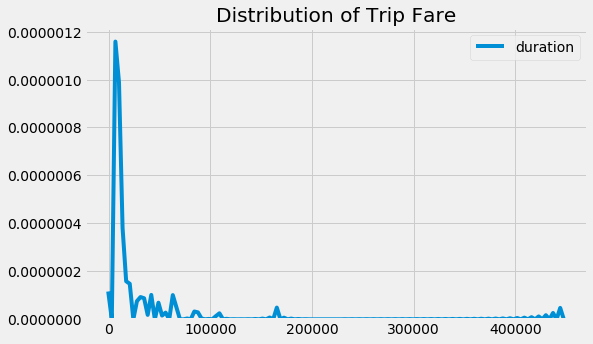

In [46]:
plt.figure(figsize=(8,5))
sns.kdeplot(test['duration']).set_title("Distribution of Trip Fare")

In [47]:
train.loc[train['meter_waiting_till_pickup']<0].shape

(0, 23)

Text(0.5, 1.0, 'Distribution of fare amount (log scale)')

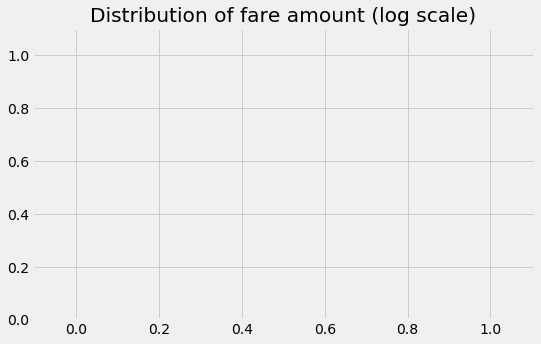

In [48]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['fare'].values)).set_title("Distribution of fare amount (log scale)")

## Pickup Location Analysis

In [49]:
print("Range of pickup Longitude is ", (min(test['pick_lon']),max(test['pick_lon'])))
print("Range of Pickup Latitude is ", (min(test['pick_lat']),max(test['pick_lat'])))
test[(test.pick_lat==0) | (test.pick_lon)==0 | (test.drop_lat==0)|(test.drop_lon==0)].shape

Range of pickup Longitude is  (79.8177, 80.7764)
Range of Pickup Latitude is  (5.94313, 8.42501)


(0, 22)

In [50]:
boundary={'min_lng':79.818,
              'min_lat':5.94313,
              'max_lng':80.8055, 
              'max_lat':8.42501}

In [51]:
train.loc[~((train.pick_lon >= boundary['min_lng'] ) & (train.pick_lon <= boundary['max_lng']) &
            (train.pick_lat >= boundary['min_lat']) & (train.pick_lat <= boundary['max_lat']) &
            (train.drop_lon >= boundary['min_lng']) & (train.drop_lon <= boundary['max_lng']) &
            (train.drop_lat >=boundary['min_lat']) & (train.drop_lat <= boundary['max_lat'])),'is_outlier_loc']=1
train.loc[((train.pick_lon >= boundary['min_lng'] ) & (train.pick_lon <= boundary['max_lng']) &
            (train.pick_lat >= boundary['min_lat']) & (train.pick_lat <= boundary['max_lat']) &
            (train.drop_lon >= boundary['min_lng']) & (train.drop_lon <= boundary['max_lng']) &
            (train.drop_lat >=boundary['min_lat']) & (train.drop_lat <= boundary['max_lat'])),'is_outlier_loc']=0

test.loc[~((test.pick_lon >= boundary['min_lng'] ) & (test.pick_lon <= boundary['max_lng']) &
            (test.pick_lat >= boundary['min_lat']) & (test.pick_lat <= boundary['max_lat']) &
            (test.drop_lon >= boundary['min_lng']) & (test.drop_lon <= boundary['max_lng']) &
            (test.drop_lat >=boundary['min_lat']) & (test.drop_lat <= boundary['max_lat'])),'is_outlier_loc']=1
test.loc[((test.pick_lon >= boundary['min_lng'] ) & (test.pick_lon <= boundary['max_lng']) &
            (test.pick_lat >= boundary['min_lat']) & (test.pick_lat <= boundary['max_lat']) &
            (test.drop_lon >= boundary['min_lng']) & (test.drop_lon <= boundary['max_lng']) &
            (test.drop_lat >=boundary['min_lat']) & (test.drop_lat <= boundary['max_lat'])),'is_outlier_loc']=0           

# print("Outlier vs Non Outlier Counts")
# print(train['is_outlier_loc'].value_counts())
# print('Old size: %d' % len(train))
# # Let us drop rows, where location is outlier
# train=train.loc[train['is_outlier_loc']==0]
# train.drop(['is_outlier_loc'],axis=1,inplace=True)
# train = train[train.duration>=0]
# print('New size: %d' % len(train))
# print (train[train.label == 0].shape[0])


train_is_outlier_loc = train['is_outlier_loc'].astype(int)
test_outlier_loc = test['is_outlier_loc'].astype(int)

train['is_outlier_loc'] = train_is_outlier_loc
test['is_outlier_loc'] = test_outlier_loc

(5.9366, 8.42173)

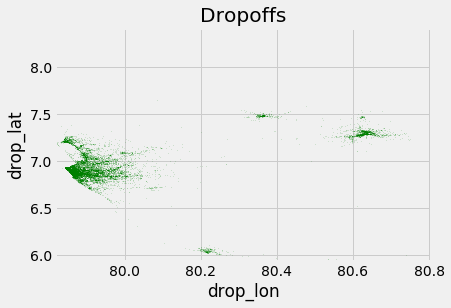

In [52]:
city_long_border = (79.818, 80.8055)
city_lat_border = (5.9366, 8.42173)

train.plot(kind='scatter', x='drop_lon', y='drop_lat',
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.xlim(city_long_border)
plt.ylim(city_lat_border)


(79.818, 80.8055)

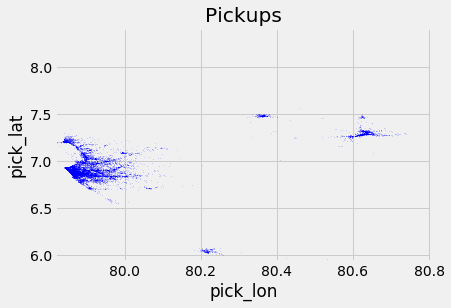

In [53]:
train.plot(kind='scatter', x='pick_lon', y='pick_lat',
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

## Drop Negative Values 

In [54]:
# print('Old size: %d' % len(train))
# train = train.dropna(how = 'any', axis = 'rows')
# print('New size: %d' % len(train))

In [55]:
# train['pickup_latitude_round3']=train['pick_lat'].apply(lambda x:round(x,3))
# train['pickup_longitude_round3']=train['pick_lon'].apply(lambda x:round(x,3))
# train['dropoff_latitude_round3']=train['drop_lat'].apply(lambda x:round(x,3))
# train['dropoff_longitude_round3']=train['drop_lon'].apply(lambda x:round(x,3))

In [56]:
# pickup_fare_amount=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['fare'].mean().reset_index().rename(columns={'fare':'avg_fare'})
# pickup_fare_amount.head()

## Trip Distance

In [57]:
#calculate trip distance in miles
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [58]:
train['trip_distance']=train.apply(lambda row:distance(row['pick_lat'],row['drop_lat'],row['pick_lon'],row['drop_lon']),axis=1)
test['trip_distance']=test.apply(lambda row:distance(row['pick_lat'],row['drop_lat'],row['pick_lon'],row['drop_lon']),axis=1)

Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

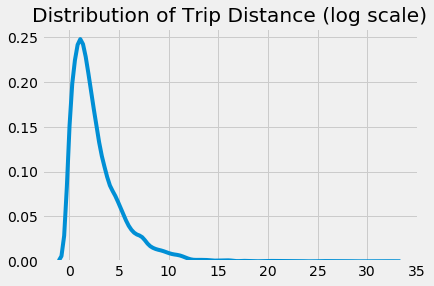

In [59]:
sns.kdeplot(test['trip_distance'].values).set_title("Distribution of Trip Distance (log scale)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

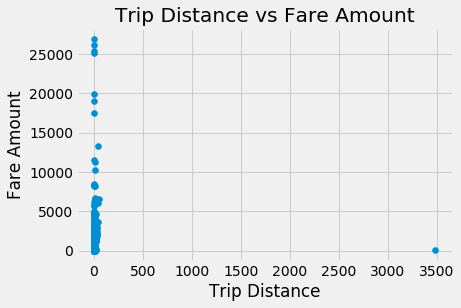

In [60]:
plt.scatter(x=train['trip_distance'],y=train['fare'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")

# Save to CSV

In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8576 entries, 0 to 8575
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   tripid                         8576 non-null   int64         
 1   additional_fare                8576 non-null   float64       
 2   duration                       8576 non-null   int64         
 3   meter_waiting                  8576 non-null   int64         
 4   meter_waiting_fare             8576 non-null   float64       
 5   meter_waiting_till_pickup      8576 non-null   int64         
 6   pickup_time                    8576 non-null   datetime64[ns]
 7   drop_time                      8576 non-null   datetime64[ns]
 8   pick_lat                       8576 non-null   float64       
 9   pick_lon                       8576 non-null   float64       
 10  drop_lat                       8576 non-null   float64       
 11  drop_lon         

In [62]:
train.to_csv("features/7_Train_FeatureEngineering_didnt_fill_null.csv",index=False)
test.to_csv("features/7_Test_FeatureEngineering_didnt_fill_null.csv",index=False)

In [63]:
!ls

 Feature_Engineering_Test.ipynb
 Feature_Engineering_Train_1.ipynb
 Feature_Engineering_Train_2.ipynb
 Feature_Engineering_Train_3_do_not_drop_any_feature.ipynb
 Feature_Engineering_Train_5_zscore_normalize.ipynb
'Feature_Engineering_Train_6_change according_to_ml_project.ipynb'
 Model.ipynb
 README.md
 catboost_info
 features
 predications_submission.csv
 predictions
 sample_submission.csv
 test.csv
 train.csv


In [64]:
print (train[train.label == 0].shape[0])

1681


In [65]:
test.head

<bound method NDFrame.head of          tripid  additional_fare  duration  meter_waiting  meter_waiting_fare  \
0     213284604  10.5             924       42             2.44860              
1     213286352  10.5             4249      20             0.00000              
2     213293973  10.5             1552      255            2.65880              
3     213294622  10.5             462       16             0.00000              
4     213298687  10.5             814       392            12.36920             
...         ...   ...             ...       ...                 ...             
8571  222856243  10.5             1723      429            24.83332             
8572  222857785  10.5             1378      80             0.00000              
8573  222858416  10.5             418       56             3.28440              
8574  222858691  10.5             1604      548            31.67440             
8575  222860703  10.5             1698      691            32.88820            